<a href="https://colab.research.google.com/github/alessiodevoto/NeuralNetworks_project/blob/main/Data_Analysis_and_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and framework

In [ ]:
!python -c "import torch; print(torch.__version__)"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.9.0+cu102.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.9.0+cu102.html
!pip install torch-geometric
!pip install wget
!pip install pickle5
!pip install 
!pip install pytorch-metric-learning[with-hooks]

In [2]:
cd /content/drive/MyDrive/gcn

/content/drive/MyDrive/gcn


# Dataset
The new PoleDataset class builds up a dataset of graphs, one for each photo in data. 
Each graph (built from a photo) represents a pylon. Each pylon belong to a different electrical line. 
Let's just download the complete data, without filtering out any graph, and explore the properties. 

In [3]:
%matplotlib inline
from PoleDataset import PoleDataset
data = PoleDataset(
    root='data',              # directory where to store data
    password='matching',      # password to extract 
    is_validation_set=False,  # whether this is gonna be a validation set
    num_pylons = -1,          # number of pylons we want to download. -1 = use all pylons
    edge_range=(-1, -1),      # if we want to filter out the edges, we insert the range here (-1,-1) = keep all
    keep_lines = None,        # if we only want pylons from specific lines, insert list of lines here
    scale_factor=100          # because bbox areas and distances are so small, we increase them by scale_factor
    )


Processing...


Retrieving information about relations between assets...
Processing datasets in json format...
Parsing dataset file: data/raw/datasets/D110-36742.json
Parsing dataset file: data/raw/datasets/D550-19031.json
Parsing dataset file: data/raw/datasets/D340-33954.json
Parsing dataset file: data/raw/datasets/D260-26837.json
Parsing dataset file: data/raw/datasets/D550-47654.json
Parsing dataset file: data/raw/datasets/D110-11881.json
Parsing dataset file: data/raw/datasets/D340-49418.json
Parsing dataset file: data/raw/datasets/D260-49027.json
Building graphs...
Number of elements not included (unprocessed photos): 789
Total number of processed graphs: 9444
Extracting desired number of pylons (might take a while)...
Collating...


Done!


Dataset ready!
Find raw data in data/raw and processed data in data/processed


Once the dataset is downloaded, we can explore its properties. 

``` dataset.info() ``` gives us general info about the dataset, whereas ``` dataset.per_line_info() ``` gives us info about the dataset grouping pylons by line. In both cases we can use the option ``` plots = True ``` to display plots. Plots display distribution of features both grouped or not grouped by graph:




Here is some info about this dataset:
Is validation dataset: False
Number of lines : 8
Lines : ['D550-19031', 'D260-49027', 'D110-36742', 'D340-49418', 'D260-26837', 'D550-47654', 'D110-11881', 'D340-33954']
Number of captured pylons: 1965
Number of graphs in dataset: 9444
Average number of graphs per pylon: 4.81
Average number of nodes per graph: 6.06
Average number of edges per graph: 49.33
Number of node features: 4
Number of edge features: 1
Dataset is undirected: True


PHOTOS PER PYLON
                 0
count  1965.000000
mean      4.806107
std       3.631241
min       1.000000
25%       2.000000
50%       4.000000
75%       6.000000
max      44.000000


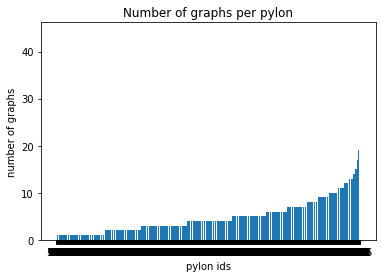


EDGES LEN
                   0
count  465832.000000
mean      227.203217
std       464.520721
min         0.000000
25%         0.000000
50%         5.469379
75%       286.369728
max      7112.226074


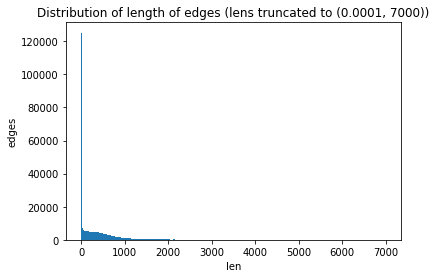


EDGE FEATURES PER GRAPH
                 0
count  9444.000000
mean    232.721837
std     197.768599
min       0.000000
25%     112.082689
50%     177.153023
75%     284.178154
max    2229.318604


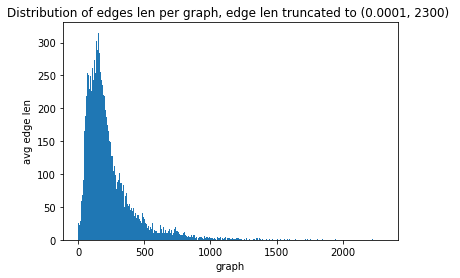


BBOX AREAS
                  0
count  57259.000000
mean       1.467806
std        3.468136
min        0.002216
25%        0.017298
50%        0.036184
75%        0.155392
max       48.182278


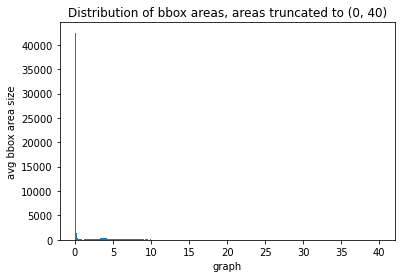


BBOX AREAS PER GRAPH
                 0
count  9444.000000
mean      1.787000
std       2.074892
min       0.154651
25%       0.846963
50%       1.276308
75%       2.000147
max      36.374863


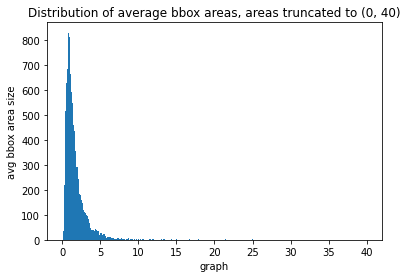

In [4]:
data.info(plots=True)

Alla luce di questo, dovremmo forse escludere dal dataset:
- gli archi fuori dal range [0.001, 4000] (vedere quanto è grande la varianza della distribuzione edge len)
- le bbox areas troppo grandi. Ache qui il 75% ha area minore di 1, e l'area massima è 48 (vedere distribuzione bbox areas)

We can now print info grouping the pylons per line.

Abbiamo da subito deciso di non inseriere le coordinate geografiche delle foto nel dataset, essendoci stato detto che erano imprecise e quindi poco utili a distinguere i pali. Tuttavia graficando le coordinate medie (x,y) di ogni foto, cioè facendo la media su x e y delle coordinate presenti per ogni foto, risultano i seguenti grafici:



Here is some info about each line contained in the dataset


INFO FOR LINE: D110-36742
num_graphs: 471 
num_pylons: 108 
avg_photos_per_pylon: 4.36
MEAN: 
latitude_mean    -0.085255
latitude_std     -0.048610
longitude_mean   -0.105988
longitude_std    -0.023419
dtype: float64
STD: 
latitude_mean     0.000331
latitude_std      0.201913
longitude_mean    0.000373
longitude_std     0.134902
dtype: float64


/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


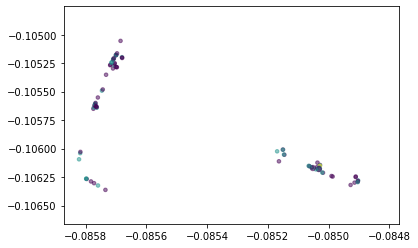



INFO FOR LINE: D550-19031
num_graphs: 366 
num_pylons: 63 
avg_photos_per_pylon: 5.81
MEAN: 
latitude_mean    -0.000022
latitude_std      0.036280
longitude_mean    0.220609
longitude_std     0.067108
dtype: float64
STD: 
latitude_mean     0.000056
latitude_std      0.245279
longitude_mean    0.000871
longitude_std     0.195323
dtype: float64


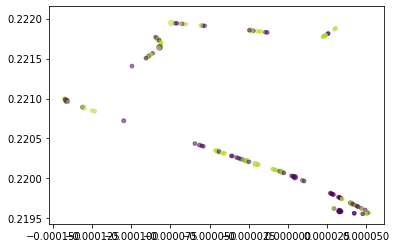



INFO FOR LINE: D340-33954
num_graphs: 2526 
num_pylons: 440 
avg_photos_per_pylon: 5.74
MEAN: 
latitude_mean     0.035885
latitude_std     -0.002026
longitude_mean   -0.081847
longitude_std    -0.030418
dtype: float64
STD: 
latitude_mean     0.000667
latitude_std      0.238607
longitude_mean    0.004138
longitude_std     0.125881
dtype: float64


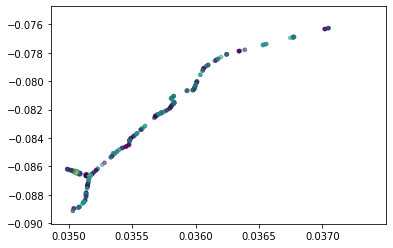



INFO FOR LINE: D260-26837
num_graphs: 1488 
num_pylons: 302 
avg_photos_per_pylon: 4.93
MEAN: 
latitude_mean     0.068302
latitude_std      0.060017
longitude_mean    0.166859
longitude_std     0.058502
dtype: float64
STD: 
latitude_mean     0.000198
latitude_std      0.263756
longitude_mean    0.002283
longitude_std     0.181004
dtype: float64


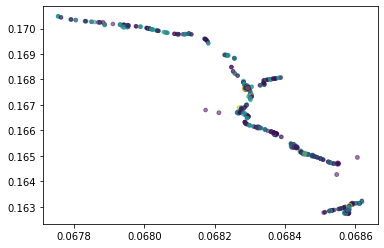



INFO FOR LINE: D550-47654
num_graphs: 199 
num_pylons: 48 
avg_photos_per_pylon: 4.15
MEAN: 
latitude_mean    -0.003058
latitude_std      0.001530
longitude_mean    0.191738
longitude_std     0.066368
dtype: float64
STD: 
latitude_mean     0.000123
latitude_std      0.236221
longitude_mean    0.000573
longitude_std     0.220867
dtype: float64


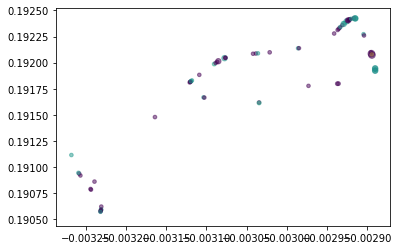



INFO FOR LINE: D110-11881
num_graphs: 2725 
num_pylons: 619 
avg_photos_per_pylon: 4.40
MEAN: 
latitude_mean    -0.081619
latitude_std     -0.048659
longitude_mean   -0.081323
longitude_std    -0.024308
dtype: float64
STD: 
latitude_mean     0.023047
latitude_std      0.196557
longitude_mean    0.019458
longitude_std     0.129671
dtype: float64


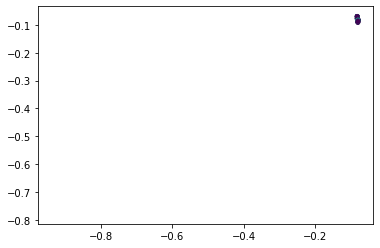



INFO FOR LINE: D340-49418
num_graphs: 1090 
num_pylons: 260 
avg_photos_per_pylon: 4.19
MEAN: 
latitude_mean     0.034719
latitude_std      0.063038
longitude_mean    0.007295
longitude_std     0.004092
dtype: float64
STD: 
latitude_mean     0.000069
latitude_std      0.274205
longitude_mean    0.001731
longitude_std     0.153421
dtype: float64


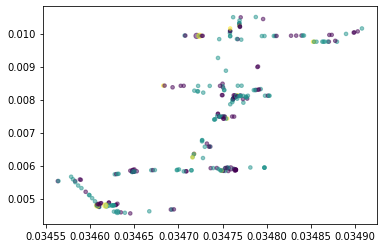



INFO FOR LINE: D260-49027
num_graphs: 579 
num_pylons: 125 
avg_photos_per_pylon: 4.63
MEAN: 
latitude_mean     0.057100
latitude_std     -0.018984
longitude_mean    0.178128
longitude_std     0.042877
dtype: float64
STD: 
latitude_mean     0.000087
latitude_std      0.231951
longitude_mean    0.001468
longitude_std     0.207415
dtype: float64


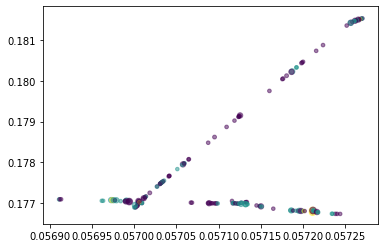

In [5]:
data.per_line_info(plots=True)

Quindi, eccezion fatta per un paio di linee, in cui sì, tutti i pali hanno le stesse coordinate, potremmo includere anche questa informazione.  

Let's now check the format of a single element of the dataset.
Every graph is stored in the dataset as a 'Data' object, with the following attributes:
- x : features matrix [num nodes, num nodes features]
- edge_idx : graph connectivity [2, num edges * 2]
- edge_attr : edge attributes [num edges, num edge features]
- photo_id : [String] the id of the photo this graph comes from
- pylon_id : [String] the id of the pylon this graph represents
- line_id : [String] the line this pylon belongs to
- y: target: [int] a numerical id representing the pylon 

In [6]:
graph0 = data[0]
print('This is a single graph object')
print(graph0)


This is a single graph object
Data(x=[3, 4], edge_index=[2, 12], edge_attr=[12, 1], y=[1], photo_id='F_2020_06_23@15.58.44(612)_Converted_CROP_1_73.jpg', pylon_id='504631_4353907_57', line_id='D110-36742')


As we can see, this graph posseses 3 nodes, each node is described by 4 features.
Let's check the content of the feature matrix x:

In [7]:
print('\ngraph.x')
print(graph0.x)


graph.x
tensor([[   17.0000,     0.6752,     0.9000,     6.7219],
        [    1.0000,     1.0000,     0.1000,     7.9195],
        [    3.0000,     0.5606,     0.9000,     0.0095]])


The features for each vector are:
- category id
- manual weight assigned by experts
- score on previous model
- bbox area

Let's also check the content of the other attributes in the graph.

In [10]:
print('\ngraph.edge_index')
print(graph0.edge_index)
print('\ngraph.edge_features')
print(graph0.edge_attr)
print('\ngraph.y')
print(graph0.y)
print('\ngraph.pylon_id')
print(graph0.pylon_id)
print('\ngraph.line_id')
print(graph0.line_id)
print('\ngraph.photo_id')
print(graph0.photo_id)


graph.edge_index
tensor([[0, 0, 0, 1, 0, 2, 1, 1, 1, 2, 2, 2],
        [0, 0, 1, 0, 2, 0, 1, 1, 2, 1, 2, 2]])

graph.edge_features
tensor([[  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [231.5686],
        [231.5686],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000]])

graph.y
tensor([543])

graph.pylon_id
504631_4353907_57

graph.line_id
D110-36742

graph.photo_id
F_2020_06_23@15.58.44(612)_Converted_CROP_1_73.jpg


# Model

Let's start by loading the data into train and validation set. Notice: we must use the is_validation_set option in the dataset and not slice the previously dowloaded one, else we end up taking random graphs from several pylons. What we want is instead to build dataset based on pylons!

Because we know from before that we have 1965 pylons, we use 1900 of them for training and 65 for validation.


In [11]:
import torch
import numpy as np
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import utils, config
from pytorch_metric_learning import losses, miners, reducers, regularizers, samplers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import single_network



# DATA LOADING

# Training and validation data
train_data = PoleDataset(root='train_data',
                         password='matching',
                         is_validation_set=False,
                         num_pylons=1900,
                         edge_range=(0.0001, 5000),   # We only keep edges in this range
                         scale_factor=100,
                         force_reprocessing=False)
train_data.info(plots=False)

# Validation data
val_data = PoleDataset(root='val_data',
                       password='matching',
                       is_validation_set=True,
                       num_pylons=65,
                       edge_range=(0.0001, 5000),
                       scale_factor=100,
                       force_reprocessing=False)
val_data.info(plots=False)

Processing...


Retrieving information about relations between assets...
Processing datasets in json format...
Parsing dataset file: train_data/raw/datasets/D550-19031.json
Parsing dataset file: train_data/raw/datasets/D110-36742.json
Parsing dataset file: train_data/raw/datasets/D340-33954.json
Parsing dataset file: train_data/raw/datasets/D260-26837.json
Parsing dataset file: train_data/raw/datasets/D550-47654.json
Parsing dataset file: train_data/raw/datasets/D110-11881.json
Parsing dataset file: train_data/raw/datasets/D260-49027.json
Parsing dataset file: train_data/raw/datasets/D340-49418.json
Building graphs...
Number of elements not included (unprocessed photos): 789
Total number of processed graphs: 9444
Extracting desired number of pylons (might take a while)...
Collating...


Done!


Dataset ready!
Find raw data in train_data/raw and processed data in train_data/processed


Here is some info about this dataset:
Is validation dataset: False
Number of lines : 8
Lines : ['D550-19031', 'D260-49027', 'D110-36742', 'D340-49418', 'D260-26837', 'D550-47654', 'D110-11881', 'D340-33954']
Number of captured pylons: 1900
Number of graphs in dataset: 9156
Average number of graphs per pylon: 4.82
Average number of nodes per graph: 6.06
Average number of edges per graph: 31.81
Number of node features: 4
Number of edge features: 1
Dataset is undirected: True




Processing...


Retrieving information about relations between assets...
Processing datasets in json format...
Parsing dataset file: val_data/raw/datasets/D110-36742.json
Parsing dataset file: val_data/raw/datasets/D550-19031.json
Parsing dataset file: val_data/raw/datasets/D340-33954.json
Parsing dataset file: val_data/raw/datasets/D260-26837.json
Parsing dataset file: val_data/raw/datasets/D550-47654.json
Parsing dataset file: val_data/raw/datasets/D110-11881.json
Parsing dataset file: val_data/raw/datasets/D340-49418.json
Parsing dataset file: val_data/raw/datasets/D260-49027.json
Building graphs...
Number of elements not included (unprocessed photos): 789
Total number of processed graphs: 9444
Extracting desired number of pylons (might take a while)...
Collating...


Done!


Dataset ready!
Find raw data in val_data/raw and processed data in val_data/processed


Here is some info about this dataset:
Is validation dataset: True
Number of lines : 7
Lines : ['D550-19031', 'D110-36742', 'D340-49418', 'D260-26837', 'D550-47654', 'D110-11881', 'D340-33954']
Number of captured pylons: 65
Number of graphs in dataset: 288
Average number of graphs per pylon: 4.43
Average number of nodes per graph: 6.25
Average number of edges per graph: 35.46
Number of node features: 4
Number of edge features: 1
Dataset is undirected: True




We now use pytorch metric learning library to mine triplets to be fed to the net. 
Note: from now on we use target or class to refere to the pylon id, because we can see the photos capturing the same pylon as beloging to the same class. 

We are going to define:
- A sampler, that creates batches of size config.batch_size (64) according to specific rules 
- A dataloader, which is nothing but a plain Pytorch dataloader
- A miner, that selects on wich triplets the loss function should be used, once the embeddings are already computed
- A loss function, that works with triplets
- A reducer, that computes a reduction of the loss function to a scalar (e.g. computing the mean)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Samplers (data miners)
# This sampler extracts m elements of each class (i.e. capturing the same pylon) 
batch_size = config.batch_size
train_labels = torch.cat([elem.y for elem in train_data])
train_sampler = samplers.MPerClassSampler(labels=train_labels, m=8, batch_size=config.batch_size)
val_labels = torch.cat([elem.y for elem in val_data])
val_sampler = samplers.MPerClassSampler(labels=val_labels, m=8, batch_size=config.batch_size)

# Dataloaders
train_loader = DataLoader(train_data, batch_size=config.batch_size, sampler=train_sampler)
val_loader = DataLoader(val_data, batch_size=config.batch_size, sampler=val_sampler)

"""LOSS SETTINGS"""
miner = miners.BatchEasyHardMiner()
reducer = reducers.MeanReducer()
# reducer = reducers.AvgNonZeroReducer()
criterion = losses.TripletMarginLoss(reducer=reducer)

"""GENERAL TRAINING SETTINGS and MODEL"""
learning_rate = 0.0001
num_epochs = 80

model = single_network.SingleGraphEmbeddingNet(config.get_network_settings())
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Built model with following settings:
{'num_categories': 49, 'categorical_embedding_dim': 32, 'linear_embedding_layers': (52, 52), 'convolutional_layers': (64, 64), 'concat_convolutions': False, 'aggregator_out_dim': 72, 'pooling': 'max', 'kernel_size': 3, 'stride': 2, 'padding': 0}


We can now define the training and validation routine. 

In [15]:
# Training routine for one epoch

def train_epoch(epoch, train_loader):
    # Training
    model.train()
    train_losses = []
    for i, batch in enumerate(train_loader):
        x, edge_index, edge_attr, y, batch_map = batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(
            device), batch.y.to(device), batch.batch.to(device)
        # Get the embedding for each graph in batch:    
        embeddings = model(x, edge_index, batch_map) 
        # Select hardest embeddings:   
        mined_embeddings = miner(embeddings, y) if miner is not None else None
        # Compute the loss:
        train_loss = criterion(embeddings, y, mined_embeddings)  
        train_losses.append(train_loss)
        # Derive, update and clear gradients:
        train_loss.backward()  
        optimizer.step() 
        optimizer.zero_grad()  
    print(
        f'\n\nEpoch: {epoch:03d}, \n'
        f'Train loss: {torch.stack(train_losses).mean()}'
    )


In [20]:
# Validation routine for one epoch
def test_epoch(epoch, val_loader):
    
    model.eval()
    
    # Variables to store epoch info
    val_losses = []
    epoch_accuracies = []
    epoch_auc = []
    epoch_distances = []
    all_y = []
    all_emb = []

    # Accuracy calculator from pytorch metric learnign library, to be used later 
    calc = AccuracyCalculator(include=(['mean_average_precision']),
                              exclude=(),
                              avg_of_avgs=False,
                              k=30,
                              label_comparison_fn=None)
    
    # Iterate in batches over dataset
    for i, batch in enumerate(val_loader):  
        x, edge_index, edge_attr, y, batch_map = batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(
            device), batch.y.to(device), batch.batch.to(device)
        embeddings = model(x, edge_index, batch_map)
        
        # We store embeddings and labels for later evaluation
        all_emb.append(embeddings)
        all_y.append(y)

        # Same as before
        mined_embeddings = miner(embeddings, y) if miner is not None else embeddings
        val_loss = criterion(embeddings, y, mined_embeddings) 
        val_losses.append(val_loss)

        
        with torch.no_grad():
            # Indices of embeddings selected by miner
            anc = embeddings[mined_embeddings[0]]
            pos = embeddings[mined_embeddings[1]]
            neg = embeddings[mined_embeddings[3]]

            # Compute the distances between anchors, positives and negatives
            pos_dist = F.pairwise_distance(anc, pos, keepdim=True).to(device)
            neg_dist = F.pairwise_distance(anc, neg, keepdim=True).to(device)

            # Basic accuracy evaluation
            # Ha senso fare questo calcolo? Forse no
            acc = torch.where(pos_dist < neg_dist, 1, 0).float().to(device)
            epoch_accuracies.append(acc)

            # ROC based evaluation
            # Build vector labels for distances
            one_label = torch.ones_like(pos_dist).to(device)
            zero_label = torch.zeros_like(neg_dist).to(device)
            # Add labels to anc-pos and anc-neg ditance   
            labelled_pos_dist = torch.cat((pos_dist, one_label), 1)
            labelled_neg_dist = torch.cat((neg_dist, zero_label), 1)
            distances = torch.cat((labelled_pos_dist, labelled_neg_dist), 0)
            epoch_distances.append(distances)
            # Just to make it clear the vector distances is now of the form:
            # [distance, label] where
            # label is 1 if distance is anchor positive, 0 if distance is anchor negative
    
    # MANUALLY COMPUTE ACCURACIES: 

    total_distances = torch.cat(epoch_distances)
    # Again, just to make it clear the vector distances is now of the form:
    # [distance, label] where
    # label is 1 if distance is anchor positive, 0 if distance is anchor negative

    auc = utils.auc(total_distances[:, 0], total_distances[:, 1], epoch)
    total_acc = torch.cat(epoch_accuracies)

    print(
        f'Val loss: {torch.stack(val_losses).mean()},\n'
        f'METRICS -> Accuracy: {total_acc.mean()}, AUC: {auc}\n'
        f'THRESHOLD -> pos mean dist {total_distances[:, 0].mean()}, neg mean dist {total_distances[:, 1].mean()}'
    )

    # COMPUTE ACCURACIES WITH LIBRARY FEATURE:

    total_emb = torch.cat(all_emb).cpu().detach().numpy()
    total_y = torch.cat(all_y).cpu().detach().numpy()
    # These two vector store all the embeddings together with their label

    accs = calc.get_accuracy(
        query=total_emb,
        reference=total_emb,
        query_labels=total_y,
        reference_labels=total_y,
        embeddings_come_from_same_source=True)

    print(accs)



Let's train the net 



Epoch: 000, 
Train loss: 0.0011174213141202927


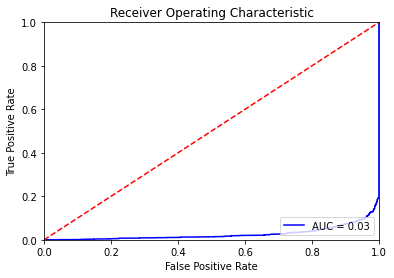

Val loss: 0.000993877649307251,
METRICS -> Accuracy: 0.9919072389602661, AUC: 0.02673111877064671
THRESHOLD -> pos mean dist 0.320402055978775, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 001, 
Train loss: 0.0009495500125922263


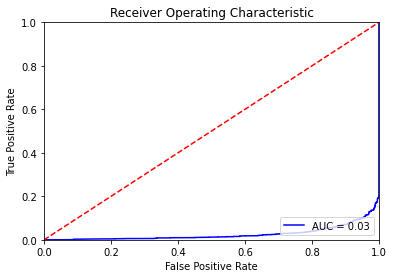

Val loss: 0.0009169047698378563,
METRICS -> Accuracy: 0.992387592792511, AUC: 0.0261342582491314
THRESHOLD -> pos mean dist 0.3457799255847931, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 002, 
Train loss: 0.0010023704962804914


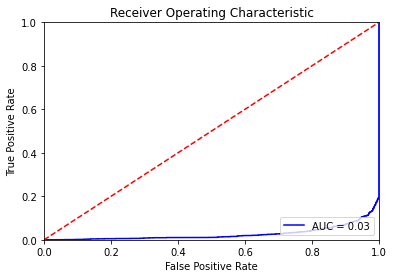

Val loss: 0.0010059261694550514,
METRICS -> Accuracy: 0.9909371137619019, AUC: 0.026801436174684733
THRESHOLD -> pos mean dist 0.3448208272457123, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 003, 
Train loss: 0.000972361012827605


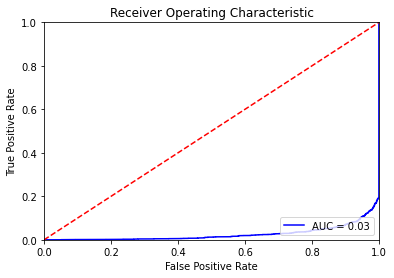

Val loss: 0.0008123326115310192,
METRICS -> Accuracy: 0.9900856018066406, AUC: 0.025567802916639997
THRESHOLD -> pos mean dist 0.3194475769996643, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 004, 
Train loss: 0.0009428350022062659


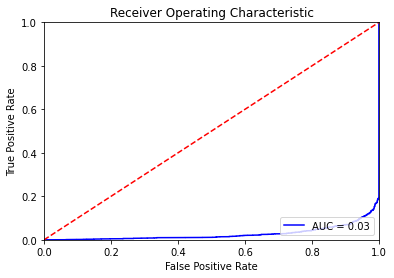

Val loss: 0.0009103708434849977,
METRICS -> Accuracy: 0.9907468557357788, AUC: 0.026834735618124887
THRESHOLD -> pos mean dist 0.34789925813674927, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 005, 
Train loss: 0.00088626763317734


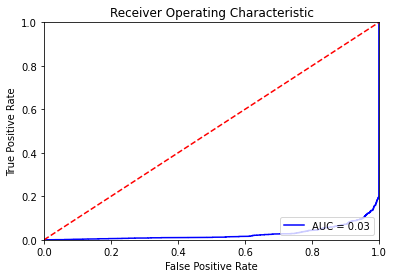

Val loss: 0.0008730012341402471,
METRICS -> Accuracy: 0.9918074011802673, AUC: 0.026817028151953567
THRESHOLD -> pos mean dist 0.3492611348628998, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 006, 
Train loss: 0.0008549730991944671


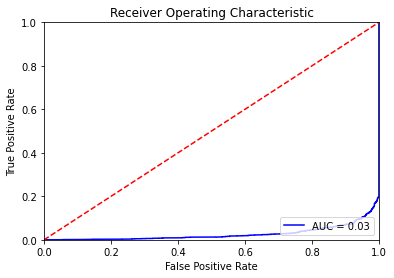

Val loss: 0.0008216347778216004,
METRICS -> Accuracy: 0.9908967018127441, AUC: 0.026678908406466126
THRESHOLD -> pos mean dist 0.33563175797462463, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 007, 
Train loss: 0.0009215449099428952


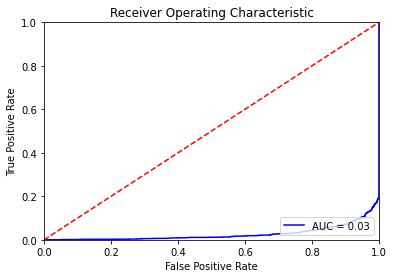

Val loss: 0.0008305422961711884,
METRICS -> Accuracy: 0.9911971688270569, AUC: 0.026274945574613323
THRESHOLD -> pos mean dist 0.3388575315475464, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 008, 
Train loss: 0.000824547023512423


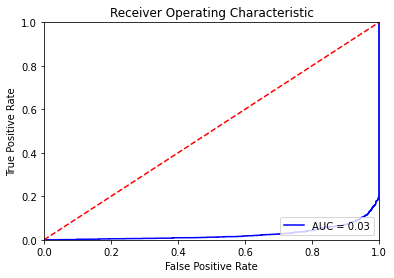

Val loss: 0.0008455651113763452,
METRICS -> Accuracy: 0.9900468587875366, AUC: 0.026607917742704556
THRESHOLD -> pos mean dist 0.3486953377723694, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 009, 
Train loss: 0.0008708105888217688


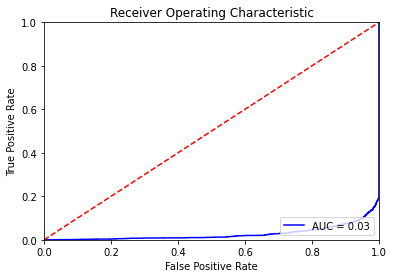

Val loss: 0.0007504099630750716,
METRICS -> Accuracy: 0.9900268316268921, AUC: 0.026967783670047783
THRESHOLD -> pos mean dist 0.3402479588985443, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 010, 
Train loss: 0.000863378110807389


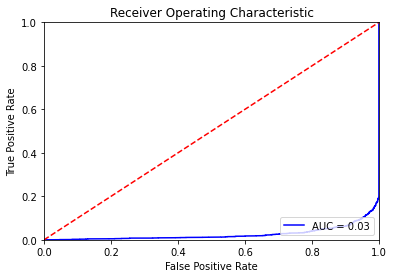

Val loss: 0.0007857473683543503,
METRICS -> Accuracy: 0.9920170307159424, AUC: 0.025778021356792902
THRESHOLD -> pos mean dist 0.3621540665626526, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 011, 
Train loss: 0.0007974533946253359


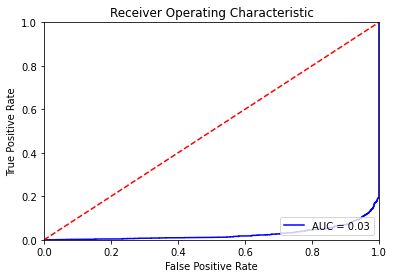

Val loss: 0.0007384238415397704,
METRICS -> Accuracy: 0.9912772178649902, AUC: 0.026864909891363697
THRESHOLD -> pos mean dist 0.3658841848373413, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 012, 
Train loss: 0.0007754254620522261


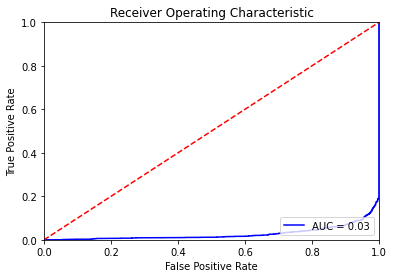

Val loss: 0.0007941170479170978,
METRICS -> Accuracy: 0.9905570149421692, AUC: 0.02705300165082916
THRESHOLD -> pos mean dist 0.3735654950141907, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 013, 
Train loss: 0.0007565517444163561


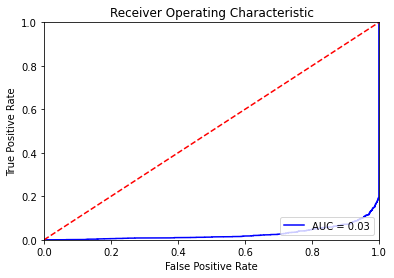

Val loss: 0.0007587089785374701,
METRICS -> Accuracy: 0.9905269742012024, AUC: 0.02701054363204484
THRESHOLD -> pos mean dist 0.3915637731552124, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 014, 
Train loss: 0.0007694265805184841


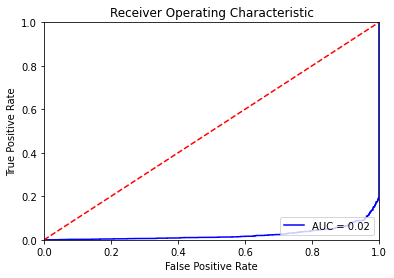

Val loss: 0.0007411027909256518,
METRICS -> Accuracy: 0.9924476146697998, AUC: 0.02485881509611885
THRESHOLD -> pos mean dist 0.3834831118583679, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 015, 
Train loss: 0.0007486423128284514


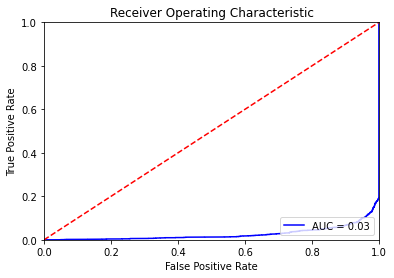

Val loss: 0.000787911587394774,
METRICS -> Accuracy: 0.9907470345497131, AUC: 0.02623387299236652
THRESHOLD -> pos mean dist 0.3692571520805359, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 016, 
Train loss: 0.0007754344842396677


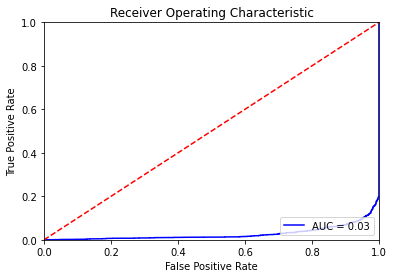

Val loss: 0.0007805688655935228,
METRICS -> Accuracy: 0.9912569522857666, AUC: 0.026938771740218616
THRESHOLD -> pos mean dist 0.3973219692707062, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 017, 
Train loss: 0.0006788566242903471


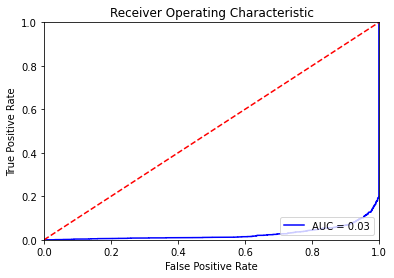

Val loss: 0.0007304360624402761,
METRICS -> Accuracy: 0.991077184677124, AUC: 0.026384547858851963
THRESHOLD -> pos mean dist 0.4208679795265198, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 018, 
Train loss: 0.0007276671240106225


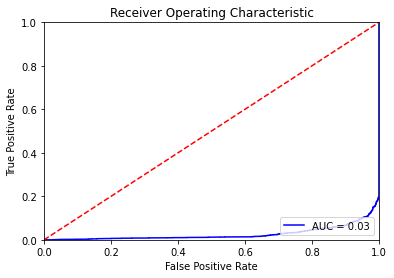

Val loss: 0.000774963409639895,
METRICS -> Accuracy: 0.9918074011802673, AUC: 0.026171741234403717
THRESHOLD -> pos mean dist 0.4093402028083801, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 019, 
Train loss: 0.0007388198282569647


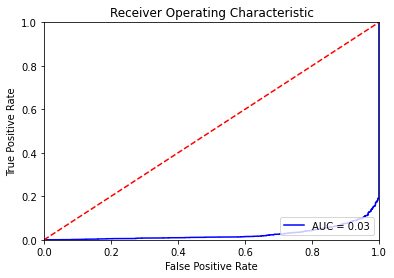

Val loss: 0.0007414371939375997,
METRICS -> Accuracy: 0.9923976063728333, AUC: 0.026483871966109823
THRESHOLD -> pos mean dist 0.3696817457675934, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 020, 
Train loss: 0.0007450319826602936


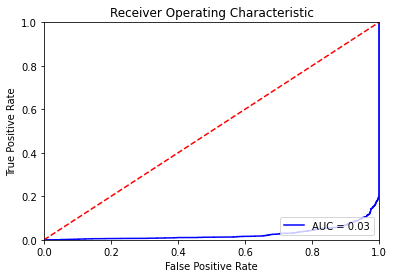

Val loss: 0.0008147385669872165,
METRICS -> Accuracy: 0.9927876591682434, AUC: 0.026209021399961542
THRESHOLD -> pos mean dist 0.4149741232395172, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 021, 
Train loss: 0.0007212466443888843


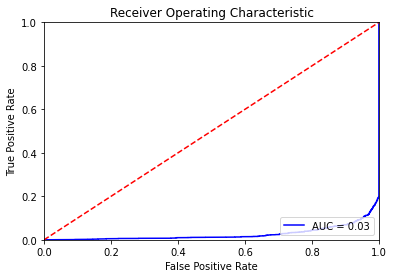

Val loss: 0.000679373275488615,
METRICS -> Accuracy: 0.992247462272644, AUC: 0.025913527706302994
THRESHOLD -> pos mean dist 0.41225796937942505, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 022, 
Train loss: 0.0006887377239763737


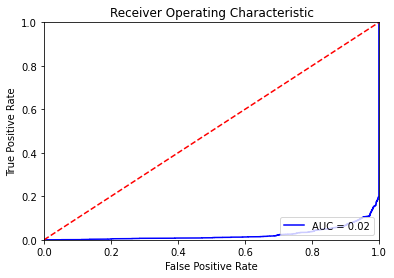

Val loss: 0.0006986674852669239,
METRICS -> Accuracy: 0.9944982528686523, AUC: 0.024000587368255537
THRESHOLD -> pos mean dist 0.4090564250946045, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 023, 
Train loss: 0.0006140550249256194


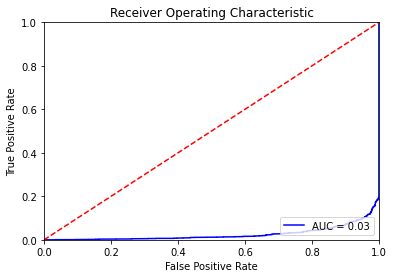

Val loss: 0.0007157494546845555,
METRICS -> Accuracy: 0.9923375844955444, AUC: 0.025447884890466486
THRESHOLD -> pos mean dist 0.40633538365364075, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 024, 
Train loss: 0.000704972306266427


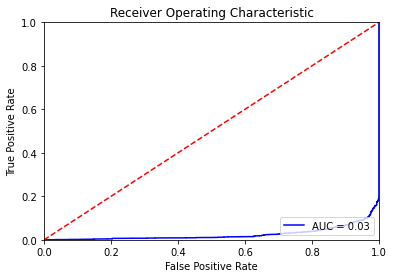

Val loss: 0.0006017466657795012,
METRICS -> Accuracy: 0.9930077791213989, AUC: 0.025030722649349586
THRESHOLD -> pos mean dist 0.43797722458839417, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 025, 
Train loss: 0.0006448192289099097


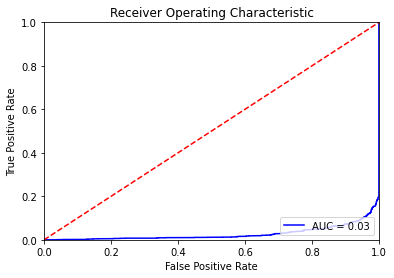

Val loss: 0.0006802929565310478,
METRICS -> Accuracy: 0.9919174313545227, AUC: 0.026913867769392353
THRESHOLD -> pos mean dist 0.41795212030410767, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 026, 
Train loss: 0.0006920880987308919


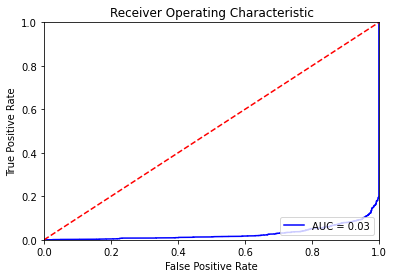

Val loss: 0.0007032275316305459,
METRICS -> Accuracy: 0.9909670948982239, AUC: 0.02799995830612019
THRESHOLD -> pos mean dist 0.4252387285232544, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 027, 
Train loss: 0.0006406260072253644


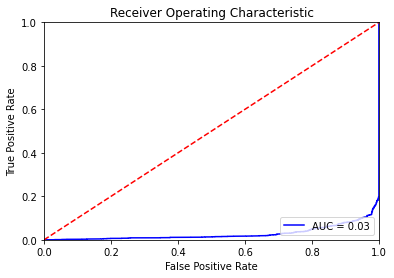

Val loss: 0.0006645991234108806,
METRICS -> Accuracy: 0.9909369945526123, AUC: 0.027656619507068797
THRESHOLD -> pos mean dist 0.43515563011169434, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 028, 
Train loss: 0.0006426621694117785


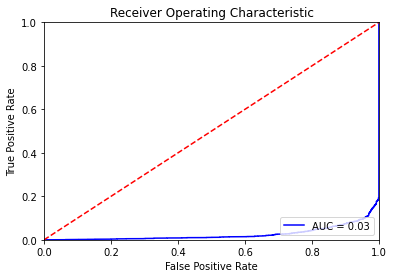

Val loss: 0.0006441836012527347,
METRICS -> Accuracy: 0.9914171695709229, AUC: 0.02556026804339545
THRESHOLD -> pos mean dist 0.40849176049232483, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 029, 
Train loss: 0.000681046862155199


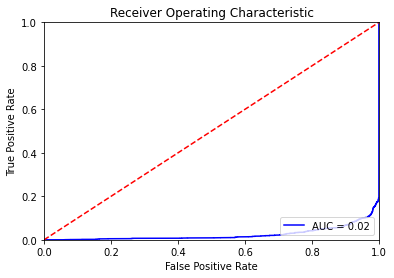

Val loss: 0.0006074728444218636,
METRICS -> Accuracy: 0.9938680529594421, AUC: 0.024295201491125684
THRESHOLD -> pos mean dist 0.42184048891067505, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 030, 
Train loss: 0.0006628338014706969


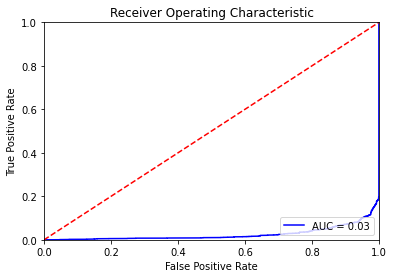

Val loss: 0.0005827631102874875,
METRICS -> Accuracy: 0.9935479760169983, AUC: 0.025198827369156337
THRESHOLD -> pos mean dist 0.40475353598594666, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 031, 
Train loss: 0.0006592996069230139


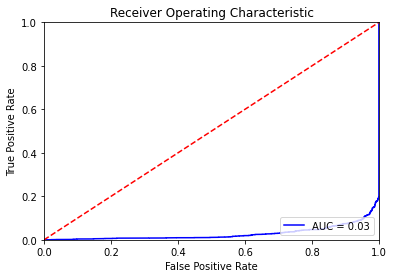

Val loss: 0.0007036313763819635,
METRICS -> Accuracy: 0.9905068874359131, AUC: 0.02775631849754529
THRESHOLD -> pos mean dist 0.4373757839202881, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 032, 
Train loss: 0.0006429522763937712


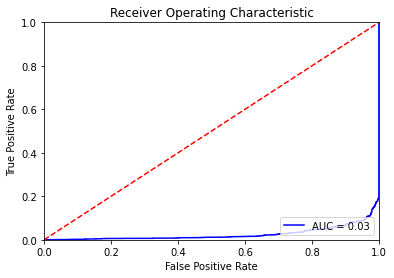

Val loss: 0.0006372499628923833,
METRICS -> Accuracy: 0.9918772578239441, AUC: 0.025477934450176896
THRESHOLD -> pos mean dist 0.4418796896934509, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 033, 
Train loss: 0.000606366666033864


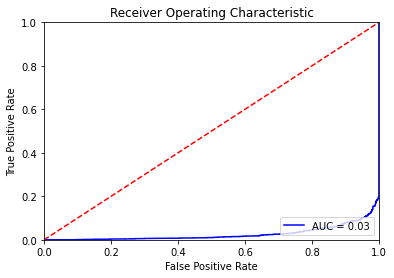

Val loss: 0.0005997440312057734,
METRICS -> Accuracy: 0.9927977323532104, AUC: 0.025913886833991744
THRESHOLD -> pos mean dist 0.42727524042129517, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 034, 
Train loss: 0.0006483341567218304


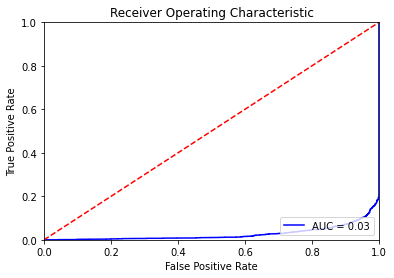

Val loss: 0.0006307816365733743,
METRICS -> Accuracy: 0.9913972020149231, AUC: 0.02632353016327533
THRESHOLD -> pos mean dist 0.4233342409133911, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 035, 
Train loss: 0.0005990731879137456


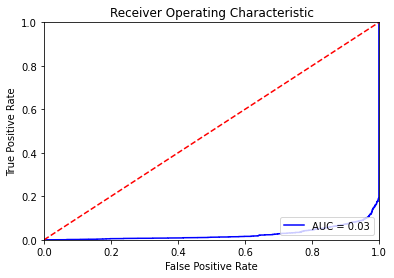

Val loss: 0.0006153345457278192,
METRICS -> Accuracy: 0.9919674396514893, AUC: 0.025874136197654954
THRESHOLD -> pos mean dist 0.4418919086456299, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 036, 
Train loss: 0.0006619610940106213


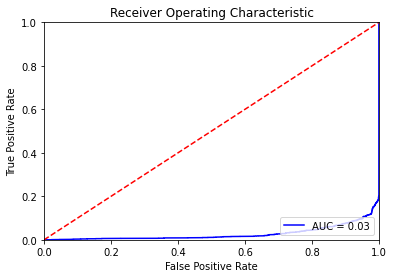

Val loss: 0.0006429484346881509,
METRICS -> Accuracy: 0.9920974969863892, AUC: 0.026901616780013647
THRESHOLD -> pos mean dist 0.43077898025512695, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 037, 
Train loss: 0.0006279972149059176


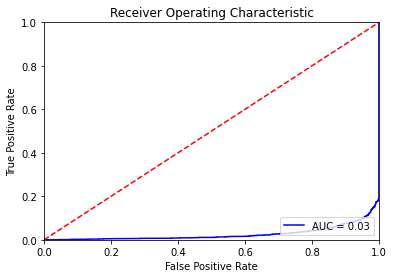

Val loss: 0.0005812654853798449,
METRICS -> Accuracy: 0.9918074011802673, AUC: 0.02610349956672435
THRESHOLD -> pos mean dist 0.44506335258483887, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 038, 
Train loss: 0.0005756753962486982


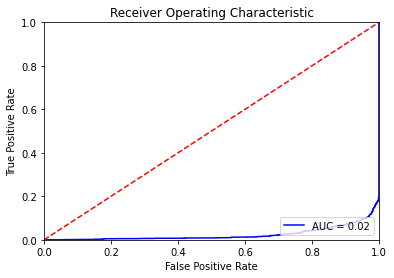

Val loss: 0.0005604180041700602,
METRICS -> Accuracy: 0.9925776124000549, AUC: 0.024144934085373385
THRESHOLD -> pos mean dist 0.44074052572250366, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 039, 
Train loss: 0.0005957209505140781


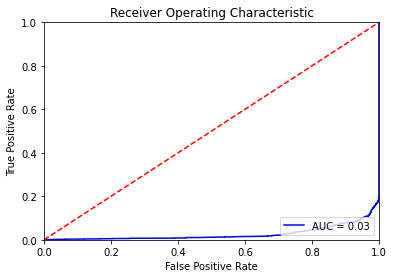

Val loss: 0.0005739082698710263,
METRICS -> Accuracy: 0.9921374917030334, AUC: 0.026320640014375663
THRESHOLD -> pos mean dist 0.4603445529937744, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 040, 
Train loss: 0.0005710296100005507


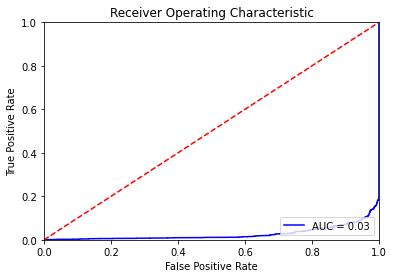

Val loss: 0.0005479634273797274,
METRICS -> Accuracy: 0.9928776621818542, AUC: 0.026180897591310516
THRESHOLD -> pos mean dist 0.43888914585113525, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 041, 
Train loss: 0.0006167549290694296


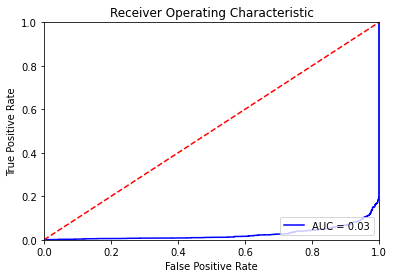

Val loss: 0.0005548704066313803,
METRICS -> Accuracy: 0.9923375844955444, AUC: 0.02604681879683573
THRESHOLD -> pos mean dist 0.44847571849823, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 042, 
Train loss: 0.0005814856267534196


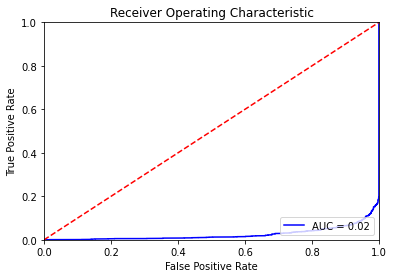

Val loss: 0.000521585694514215,
METRICS -> Accuracy: 0.992177426815033, AUC: 0.024948184885166876
THRESHOLD -> pos mean dist 0.4366509020328522, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 043, 
Train loss: 0.000531656900420785


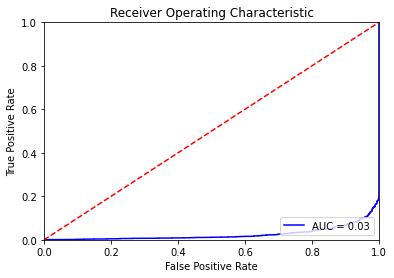

Val loss: 0.0005814109463244677,
METRICS -> Accuracy: 0.9928976893424988, AUC: 0.02534487485734898
THRESHOLD -> pos mean dist 0.45587778091430664, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 044, 
Train loss: 0.0005713340942747891


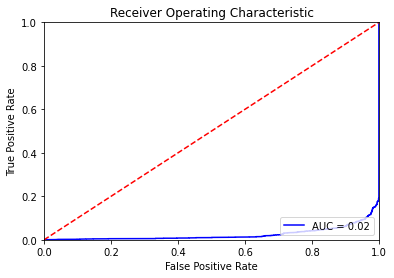

Val loss: 0.0005853065522387624,
METRICS -> Accuracy: 0.9934778809547424, AUC: 0.024199554370553093
THRESHOLD -> pos mean dist 0.4909157454967499, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 045, 
Train loss: 0.0005821281811222434


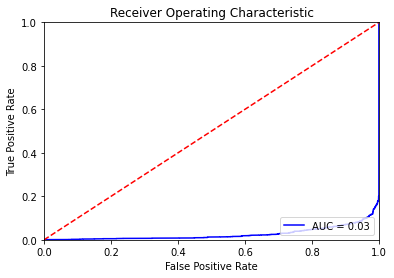

Val loss: 0.0005915535148233175,
METRICS -> Accuracy: 0.992537260055542, AUC: 0.02610849446164873
THRESHOLD -> pos mean dist 0.4568568468093872, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 046, 
Train loss: 0.0005782293737865984


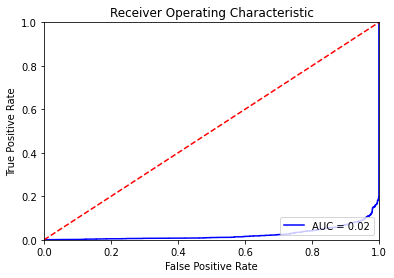

Val loss: 0.0005178839201107621,
METRICS -> Accuracy: 0.9928874373435974, AUC: 0.024643154277326884
THRESHOLD -> pos mean dist 0.47739705443382263, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 047, 
Train loss: 0.0005521014099940658


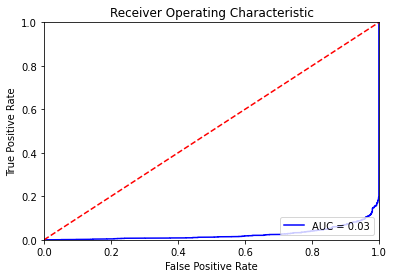

Val loss: 0.000553373945876956,
METRICS -> Accuracy: 0.9921374320983887, AUC: 0.02530655296907597
THRESHOLD -> pos mean dist 0.46455517411231995, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 048, 
Train loss: 0.0005644805496558547


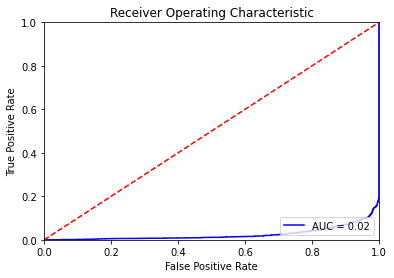

Val loss: 0.0005317559698596597,
METRICS -> Accuracy: 0.9924670457839966, AUC: 0.024834300677231105
THRESHOLD -> pos mean dist 0.4575106203556061, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 049, 
Train loss: 0.0005546457832679152


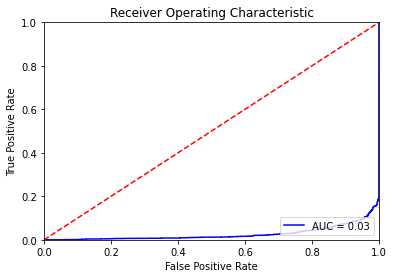

Val loss: 0.00047031432040967047,
METRICS -> Accuracy: 0.9915273189544678, AUC: 0.026203647351051185
THRESHOLD -> pos mean dist 0.4460274279117584, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 050, 
Train loss: 0.0005528258625417948


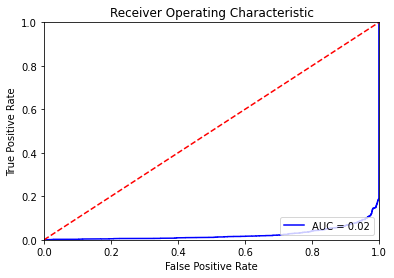

Val loss: 0.0005126988980919123,
METRICS -> Accuracy: 0.9928475022315979, AUC: 0.024332536494810646
THRESHOLD -> pos mean dist 0.4587666988372803, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 051, 
Train loss: 0.000553972611669451


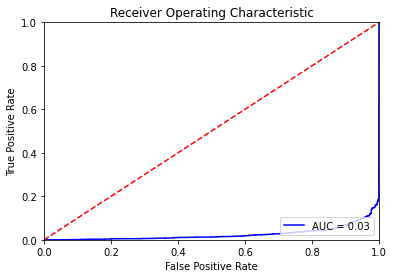

Val loss: 0.0005948724574409425,
METRICS -> Accuracy: 0.9923075437545776, AUC: 0.02563616196851686
THRESHOLD -> pos mean dist 0.44843482971191406, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 052, 
Train loss: 0.0005730499979108572


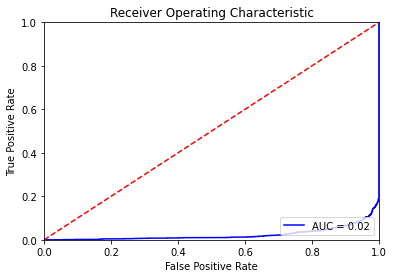

Val loss: 0.0005039991228841245,
METRICS -> Accuracy: 0.9938679933547974, AUC: 0.02379235756500516
THRESHOLD -> pos mean dist 0.42766112089157104, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 053, 
Train loss: 0.0005004532868042588


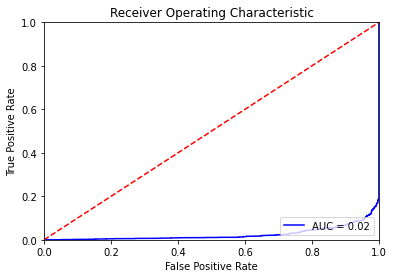

Val loss: 0.0005033071502111852,
METRICS -> Accuracy: 0.993977963924408, AUC: 0.02498863918595976
THRESHOLD -> pos mean dist 0.4249820411205292, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 054, 
Train loss: 0.0005181991145946085


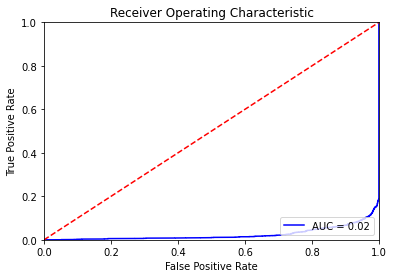

Val loss: 0.0004658866673707962,
METRICS -> Accuracy: 0.9941580891609192, AUC: 0.024588927314293248
THRESHOLD -> pos mean dist 0.44241687655448914, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 055, 
Train loss: 0.0004849268007092178


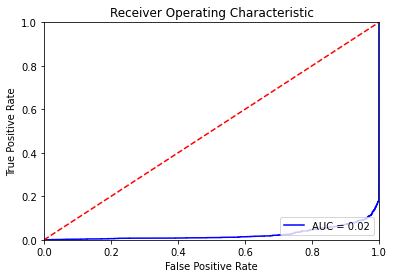

Val loss: 0.00047584029380232096,
METRICS -> Accuracy: 0.9941279292106628, AUC: 0.024922605971160583
THRESHOLD -> pos mean dist 0.43995431065559387, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 056, 
Train loss: 0.0005677050794474781


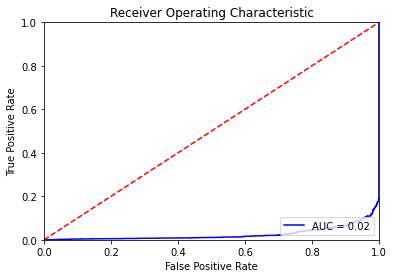

Val loss: 0.00058196164900437,
METRICS -> Accuracy: 0.9931576251983643, AUC: 0.024956792697681272
THRESHOLD -> pos mean dist 0.44416287541389465, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 057, 
Train loss: 0.0005803012754768133


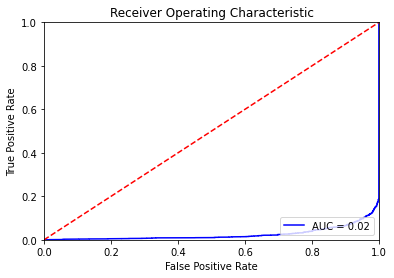

Val loss: 0.0005302988574840128,
METRICS -> Accuracy: 0.9917973279953003, AUC: 0.02493407677535077
THRESHOLD -> pos mean dist 0.475956529378891, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 058, 
Train loss: 0.0005256910226307809


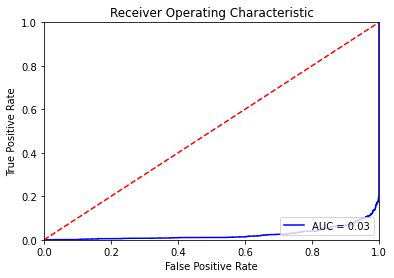

Val loss: 0.0005197664140723646,
METRICS -> Accuracy: 0.9923973679542542, AUC: 0.025050304144238707
THRESHOLD -> pos mean dist 0.45766234397888184, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 059, 
Train loss: 0.0005381502560339868


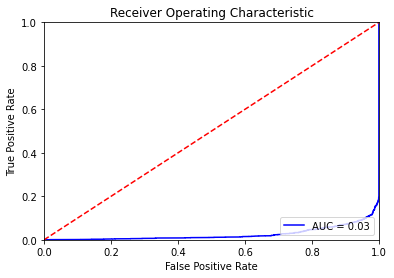

Val loss: 0.0005668366211466491,
METRICS -> Accuracy: 0.9940078258514404, AUC: 0.025091632873793512
THRESHOLD -> pos mean dist 0.432265967130661, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 060, 
Train loss: 0.0005185592453926802


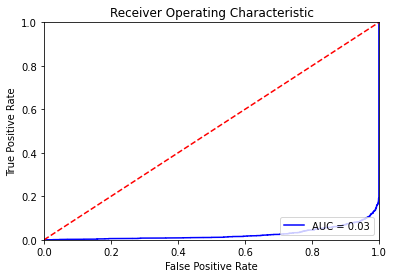

Val loss: 0.00048744396190159023,
METRICS -> Accuracy: 0.992887020111084, AUC: 0.02535367011050542
THRESHOLD -> pos mean dist 0.4613909125328064, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 061, 
Train loss: 0.0005096447421237826


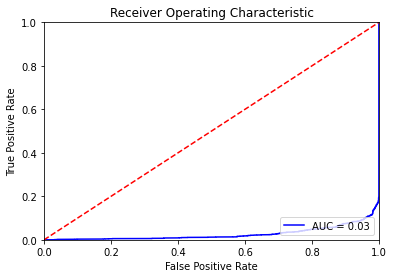

Val loss: 0.0005188186187297106,
METRICS -> Accuracy: 0.9928675889968872, AUC: 0.026419528275129618
THRESHOLD -> pos mean dist 0.4341698884963989, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 062, 
Train loss: 0.0004839285393245518


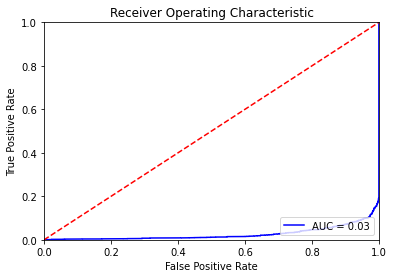

Val loss: 0.0005375028122216463,
METRICS -> Accuracy: 0.9923871159553528, AUC: 0.025904201502575264
THRESHOLD -> pos mean dist 0.45008009672164917, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 063, 
Train loss: 0.0005089828628115356


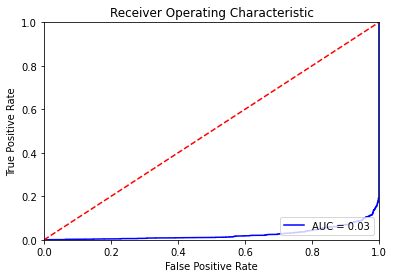

Val loss: 0.000511199701577425,
METRICS -> Accuracy: 0.9923173785209656, AUC: 0.025697197023379924
THRESHOLD -> pos mean dist 0.42985931038856506, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 064, 
Train loss: 0.00048481120029464364


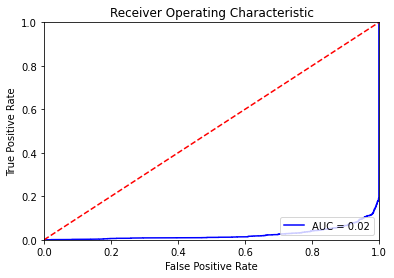

Val loss: 0.00046005117474123836,
METRICS -> Accuracy: 0.9932375550270081, AUC: 0.024690384176733457
THRESHOLD -> pos mean dist 0.4457134008407593, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 065, 
Train loss: 0.0004882746434304863


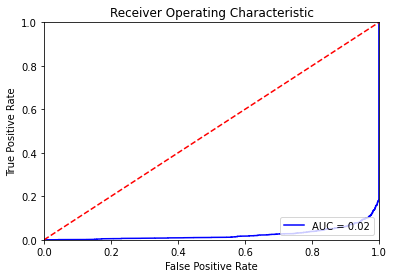

Val loss: 0.0004485691024456173,
METRICS -> Accuracy: 0.9928174018859863, AUC: 0.024081302416803306
THRESHOLD -> pos mean dist 0.4452287256717682, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 066, 
Train loss: 0.0004928730195388198


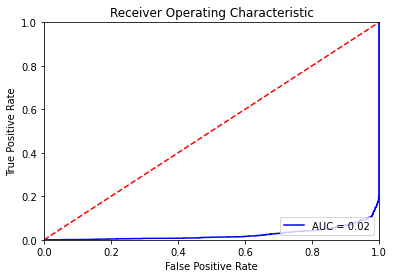

Val loss: 0.0005124579765833914,
METRICS -> Accuracy: 0.9928572177886963, AUC: 0.024571898443400096
THRESHOLD -> pos mean dist 0.4125555753707886, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 067, 
Train loss: 0.0004922906518913805


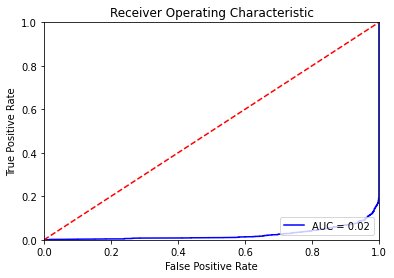

Val loss: 0.0004870366246905178,
METRICS -> Accuracy: 0.9929775595664978, AUC: 0.024358036041369546
THRESHOLD -> pos mean dist 0.4533521831035614, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 068, 
Train loss: 0.00048113311640918255


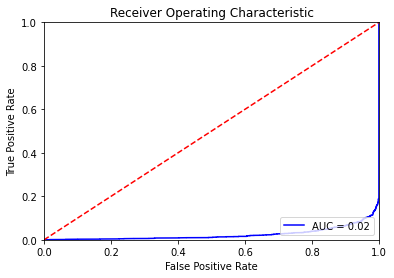

Val loss: 0.00048465776490047574,
METRICS -> Accuracy: 0.9921972751617432, AUC: 0.024470974284304663
THRESHOLD -> pos mean dist 0.4558039605617523, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 069, 
Train loss: 0.00046875092084519565


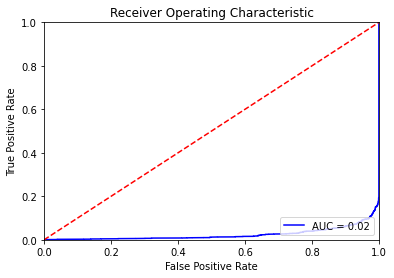

Val loss: 0.00045890998444519937,
METRICS -> Accuracy: 0.9926972389221191, AUC: 0.024006201196413824
THRESHOLD -> pos mean dist 0.45586830377578735, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 070, 
Train loss: 0.0004821718903258443


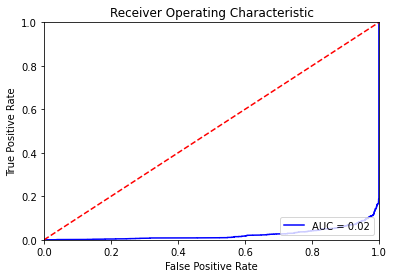

Val loss: 0.000413948146160692,
METRICS -> Accuracy: 0.9924271106719971, AUC: 0.02384870021841368
THRESHOLD -> pos mean dist 0.44391024112701416, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 071, 
Train loss: 0.00045461446279659867


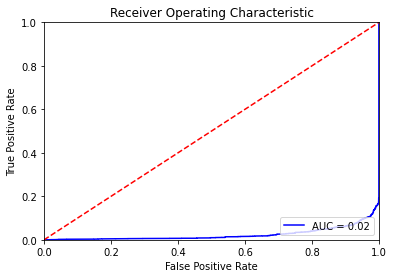

Val loss: 0.0004871876153629273,
METRICS -> Accuracy: 0.9928975701332092, AUC: 0.02371650918461708
THRESHOLD -> pos mean dist 0.4430604875087738, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 072, 
Train loss: 0.0005045832367613912


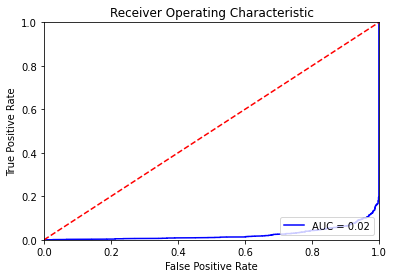

Val loss: 0.0003964889619965106,
METRICS -> Accuracy: 0.9930773973464966, AUC: 0.02432985757852825
THRESHOLD -> pos mean dist 0.43134522438049316, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 073, 
Train loss: 0.00046854326501488686


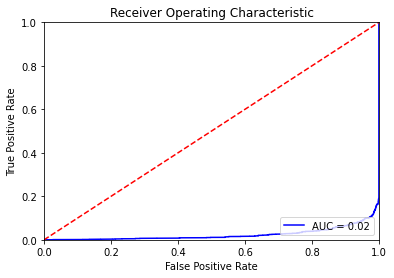

Val loss: 0.00036534632090479136,
METRICS -> Accuracy: 0.9940076470375061, AUC: 0.023765381382764048
THRESHOLD -> pos mean dist 0.4415542781352997, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 074, 
Train loss: 0.0005046350997872651


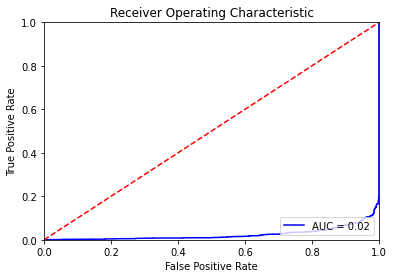

Val loss: 0.0005140555440448225,
METRICS -> Accuracy: 0.9929171800613403, AUC: 0.024334969381910425
THRESHOLD -> pos mean dist 0.4447779357433319, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 075, 
Train loss: 0.0004991692258045077


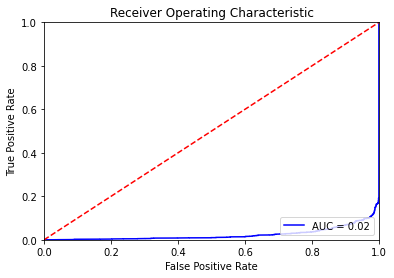

Val loss: 0.0004908576374873519,
METRICS -> Accuracy: 0.9934676289558411, AUC: 0.023882074098233924
THRESHOLD -> pos mean dist 0.47031182050704956, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 076, 
Train loss: 0.00047135594650171697


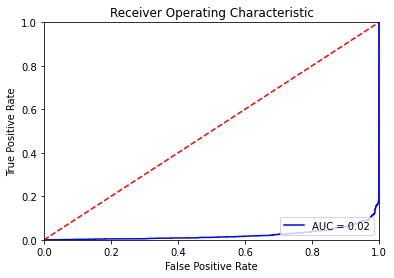

Val loss: 0.00044599935063160956,
METRICS -> Accuracy: 0.9926373362541199, AUC: 0.022885529865538518
THRESHOLD -> pos mean dist 0.45911332964897156, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 077, 
Train loss: 0.0004628686001524329


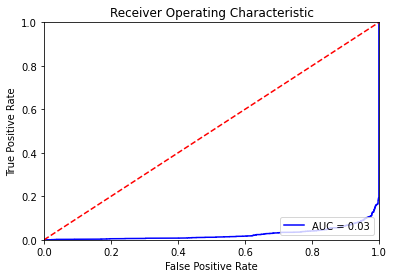

Val loss: 0.0004509665595833212,
METRICS -> Accuracy: 0.993187427520752, AUC: 0.025151035855440557
THRESHOLD -> pos mean dist 0.44147759675979614, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 078, 
Train loss: 0.0004545545671135187


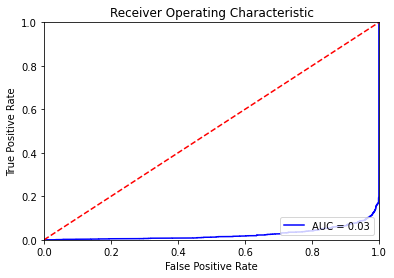

Val loss: 0.00038972211768850684,
METRICS -> Accuracy: 0.9933478236198425, AUC: 0.02503979693914595
THRESHOLD -> pos mean dist 0.44664591550827026, neg mean dist 0.5


{'mean_average_precision': 1.0}


Epoch: 079, 
Train loss: 0.00047610068577341735


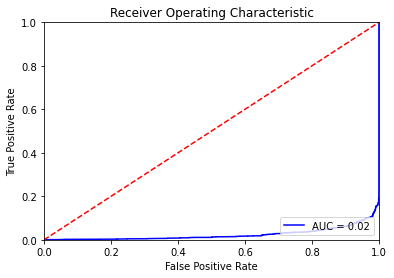

Val loss: 0.0004000349435955286,
METRICS -> Accuracy: 0.9929977655410767, AUC: 0.024061294264452714
THRESHOLD -> pos mean dist 0.4636208117008209, neg mean dist 0.5


{'mean_average_precision': 1.0}


In [22]:
for epoch in range(num_epochs):
    # Training
    train_epoch(epoch, train_loader)

    # Validation
    test_epoch(epoch, val_loader)